### Deep learning model training.


In [1]:
import time
import torch
import random
import pandas as pd
import torch.nn as nn
from glob import glob
from model import u2net 
import geopandas as gpd 
from notebooks import config
import torch.nn.functional as F
from utils.imgShow import imsShow
from utils.utils import read_scenes
from utils.metrics import oa_binary, miou_binary
from utils.dataloader import SceneArraySet, PatchPathSet, PatchPathSet_2
from model import unet, deeplabv3plus, deeplabv3plus_mobilev2, u2net
from model import u2net_att_1, u2net_att_2


In [2]:
patch_size = 512  ## patch size setting
patch_resize = None  ## patch resize setting
### traset
paths_scene_tra, paths_truth_tra = config.paths_scene_tra, config.paths_truth_tra
# paths_dem_tra = config.paths_dem_tra
paths_dem_tra = config.paths_dem_adjust_tra
print(f'train scenes: {len(paths_scene_tra)}')
### valset
# paths_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}/*'))  ## for model prediction 
paths_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}_dem_adjust/*'))
print(f'vali patch {patch_size}: {len(paths_valset)}')



train scenes: 48
vali patch 512: 293


### dataset loading

In [3]:
scenes_arr, truths_arr = read_scenes(paths_scene_tra, 
                                     paths_truth_tra, 
                                     paths_dem_tra) 


In [4]:
## Create dataset instances
tra_data = SceneArraySet(scenes_arr=scenes_arr, 
                         truths_arr=truths_arr, 
                         patch_size=patch_size,
                         patch_resize=patch_resize)
val_data = PatchPathSet_2(paths_valset=paths_valset, 
                          patch_resize=patch_resize)
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=5)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=4, 
                                         num_workers=5)


#### Model training

In [5]:
### check model
# model = unet(num_bands=7)
# model = u2net(num_bands_b1=6, num_bands_b2=1)
model = u2net_att_2(num_bands_b1=6, num_bands_b2=1)
# model = deeplabv3plus(num_bands=7)
# model = deeplabv3plus_mobilev2(num_bands=7)


In [6]:
tensor = torch.randn(2, 7, 512, 512)  
output = model(tensor) 
print(output.shape) 


torch.Size([2, 1, 512, 512])


In [7]:
### create loss and optimizer
loss_bce = nn.BCELoss()
loss_mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, \
                                      mode='min', factor=0.6, patience=20)


In [8]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y, patch_size, patch_resize):
    model.eval()
    with torch.no_grad():
        pred = model(x.float())
        if patch_size > 256:
            if patch_resize == 256:
                pred = F.interpolate(pred, 
                                size=(patch_size, patch_size), 
                                mode='bilinear',
                                align_corners=True)
            crop_start = (patch_size-256)//2
            pred = pred[:, :, crop_start:crop_start+256, crop_start:crop_start+256]  ## crop to inner 256x256 patch
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model, loss_fn, optimizer, 
                    tra_loader, val_loader, epoches, 
                    device, patch_size, patch_resize,
                    lr_scheduler=None):
    tra_loss_loops, tra_miou_loops, tra_oa_loops = [], [], []
    val_loss_loops, val_miou_loops, val_oa_loops = [], [], []
    model = model.to(device)
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                    optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        if lr_scheduler:
          lr_scheduler.step(tra_loss)    # if using ReduceLROnPlateau
        '''----- validation the model: time consuming -----'''
        if epoch %3 != 0: 
            tra_loss = tra_loss/size_tra_loader
            tra_miou = tra_miou/size_tra_loader
            tra_oa = tra_oa/size_tra_loader
            print(f'Ep{epoch+1}: tra-> Loss:{tra_loss:.3f},Oa:{tra_oa:.3f},Miou:{tra_miou:.3f}, \
                                time:{time.time()-start:.1f}s')
            continue
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = val_step(model=model, 
                                        loss_fn=loss_fn, 
                                        x=x_batch, 
                                        y=y_batch, 
                                        patch_size=patch_size, 
                                        patch_resize=patch_resize)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss); tra_miou_loops.append(tra_miou); tra_oa_loops.append(tra_oa)
        val_loss_loops.append(val_loss); val_miou_loops.append(val_miou); val_oa_loops.append(val_oa)
        print(f'Ep{epoch}: tra-> Loss:{tra_loss:.3f},Oa:{tra_oa:.3f},Miou:{tra_miou:.3f}, '
                f'val-> Loss:{val_loss:.3f},Oa:{val_oa:.3f}, Miou:{val_miou:.3f},time:{time.time()-start:.1f}s')
        ## show the result
        if (epoch+1)%20 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, truth = val_data[sam_index]
            patch, truth = torch.unsqueeze(patch.float(), 0).to(device), truth.to(device)
            pred = model(patch)
            if patch_size > 256:
                while patch_resize == 256:
                    patch = F.interpolate(patch, 
                                    size=(patch_size, patch_size), 
                                    mode='bilinear',
                                    align_corners=True)
                    pred = F.interpolate(pred, 
                                    size=(patch_size, patch_size), 
                                    mode='bilinear',
                                    align_corners=True)
                    break
                crop_start = (patch_size-256)//2                
                patch_val = patch[:, :, crop_start:crop_start+256, crop_start:crop_start+256]  ## crop to match the size
                pred_val = pred[:, :, crop_start:crop_start+256, crop_start:crop_start+256]  ## crop to match the size
            else:
                patch_val = patch
                pred_val = pred
            ## convert to numpy and plot
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pdem = patch[:,:, -1]
            patch_val = patch_val[0].to('cpu').detach().numpy().transpose(1,2,0)
            pred_val = pred_val[0].to('cpu').detach().numpy()
            truth_val = truth.to('cpu').detach().numpy()
            imsShow([patch, pdem, patch_val, pred_val, truth_val], 
                    clip_list = (2,2,2,0,0),
                    img_name_list=['input_patch', 'pdem', 'patch_val', 'pred_val', 'truth_val'],                     
                    figsize=(15, 3))
    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'tra_oa': tra_oa_loops, 
                'val_loss': val_loss_loops, 'val_miou': val_miou_loops, 'val_oa': val_oa_loops}
    return metrics 


Ep0: tra-> Loss:0.100,Oa:0.854,Miou:0.778, val-> Loss:0.175,Oa:0.618, Miou:0.444,time:4.6s
Ep2: tra-> Loss:0.079,Oa:0.848,Miou:0.687,                                 time:1.6s
Ep3: tra-> Loss:0.038,Oa:0.951,Miou:0.871,                                 time:1.6s
Ep3: tra-> Loss:0.033,Oa:0.940,Miou:0.882, val-> Loss:0.049,Oa:0.867, Miou:0.774,time:4.1s
Ep5: tra-> Loss:0.039,Oa:0.898,Miou:0.837,                                 time:1.7s
Ep6: tra-> Loss:0.018,Oa:0.943,Miou:0.899,                                 time:1.8s
Ep6: tra-> Loss:0.039,Oa:0.907,Miou:0.864, val-> Loss:0.049,Oa:0.873, Miou:0.770,time:3.9s
Ep8: tra-> Loss:0.017,Oa:0.968,Miou:0.911,                                 time:1.8s
Ep9: tra-> Loss:0.028,Oa:0.939,Miou:0.903,                                 time:1.8s
Ep9: tra-> Loss:0.030,Oa:0.943,Miou:0.868, val-> Loss:0.046,Oa:0.876, Miou:0.781,time:4.0s
Ep11: tra-> Loss:0.022,Oa:0.940,Miou:0.892,                                 time:1.7s
Ep12: tra-> Loss:0.016,Oa:0.962,Miou:0.9

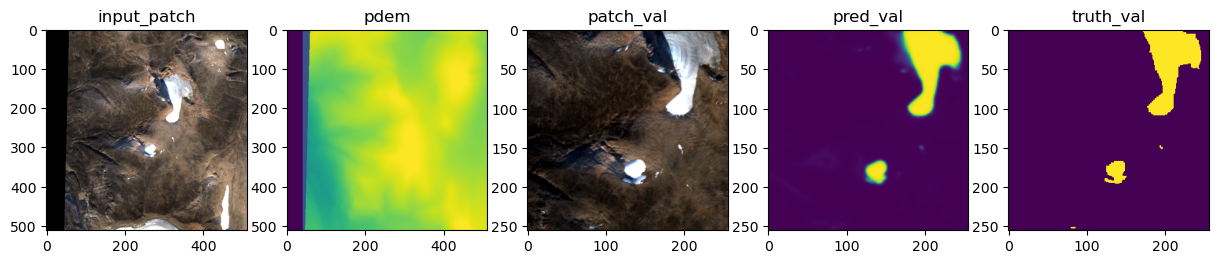

Ep41: tra-> Loss:0.014,Oa:0.953,Miou:0.921,                                 time:1.6s
Ep42: tra-> Loss:0.015,Oa:0.968,Miou:0.936,                                 time:1.7s
Ep42: tra-> Loss:0.018,Oa:0.967,Miou:0.908, val-> Loss:0.023,Oa:0.921, Miou:0.854,time:4.1s
Ep44: tra-> Loss:0.015,Oa:0.971,Miou:0.940,                                 time:1.6s
Ep45: tra-> Loss:0.018,Oa:0.964,Miou:0.937,                                 time:1.7s
Ep45: tra-> Loss:0.014,Oa:0.978,Miou:0.932, val-> Loss:0.015,Oa:0.933, Miou:0.883,time:4.3s
Ep47: tra-> Loss:0.016,Oa:0.966,Miou:0.934,                                 time:1.9s
Ep48: tra-> Loss:0.013,Oa:0.957,Miou:0.921,                                 time:1.8s
Ep48: tra-> Loss:0.015,Oa:0.944,Miou:0.898, val-> Loss:0.015,Oa:0.933, Miou:0.888,time:4.0s
Ep50: tra-> Loss:0.014,Oa:0.976,Miou:0.936,                                 time:1.7s
Ep51: tra-> Loss:0.012,Oa:0.976,Miou:0.944,                                 time:1.8s
Ep51: tra-> Loss:0.014,Oa:0.961,Miou

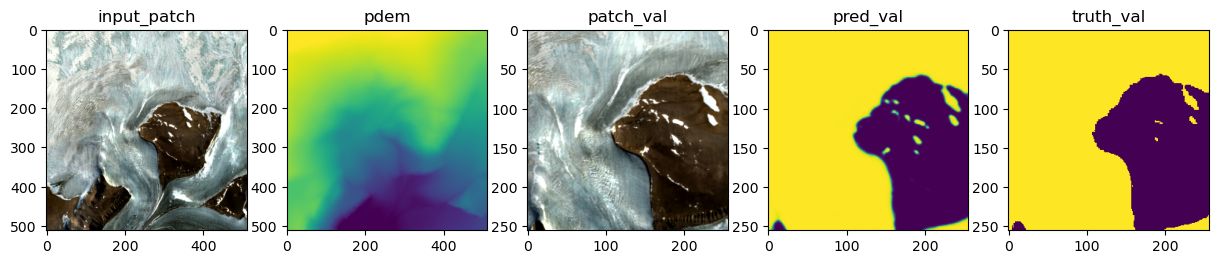

Ep101: tra-> Loss:0.010,Oa:0.978,Miou:0.927,                                 time:1.8s
Ep102: tra-> Loss:0.015,Oa:0.971,Miou:0.944,                                 time:1.6s
Ep102: tra-> Loss:0.013,Oa:0.975,Miou:0.950, val-> Loss:0.016,Oa:0.934, Miou:0.879,time:4.0s
Ep104: tra-> Loss:0.013,Oa:0.970,Miou:0.938,                                 time:1.8s
Ep105: tra-> Loss:0.017,Oa:0.972,Miou:0.933,                                 time:1.5s
Ep105: tra-> Loss:0.033,Oa:0.912,Miou:0.878, val-> Loss:0.032,Oa:0.908, Miou:0.843,time:4.2s
Ep107: tra-> Loss:0.016,Oa:0.975,Miou:0.937,                                 time:1.8s
Ep108: tra-> Loss:0.011,Oa:0.980,Miou:0.949,                                 time:1.8s
Ep108: tra-> Loss:0.012,Oa:0.969,Miou:0.940, val-> Loss:0.017,Oa:0.932, Miou:0.891,time:4.0s
Ep110: tra-> Loss:0.016,Oa:0.963,Miou:0.936,                                 time:1.9s
Ep111: tra-> Loss:0.011,Oa:0.981,Miou:0.952,                                 time:1.8s
Ep111: tra-> Loss:0.013,O

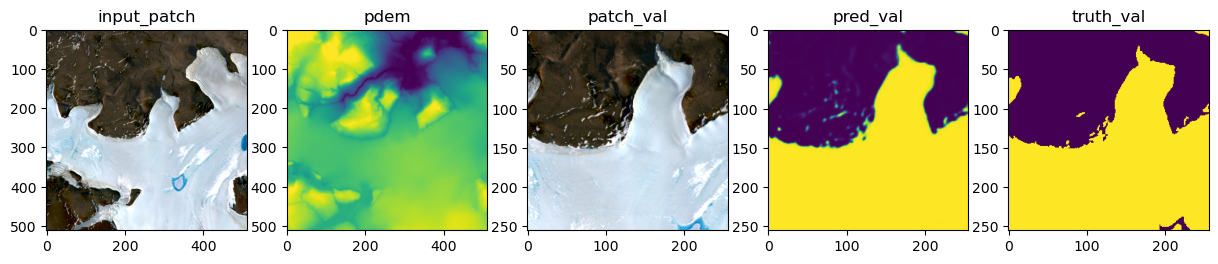

Ep161: tra-> Loss:0.009,Oa:0.982,Miou:0.956,                                 time:1.8s
Ep162: tra-> Loss:0.013,Oa:0.975,Miou:0.953,                                 time:1.8s
Ep162: tra-> Loss:0.011,Oa:0.978,Miou:0.959, val-> Loss:0.014,Oa:0.937, Miou:0.892,time:3.9s
Ep164: tra-> Loss:0.012,Oa:0.977,Miou:0.944,                                 time:1.8s
Ep165: tra-> Loss:0.009,Oa:0.983,Miou:0.960,                                 time:1.7s
Ep165: tra-> Loss:0.015,Oa:0.975,Miou:0.952, val-> Loss:0.016,Oa:0.932, Miou:0.890,time:4.0s
Ep167: tra-> Loss:0.011,Oa:0.982,Miou:0.959,                                 time:1.7s
Ep168: tra-> Loss:0.011,Oa:0.978,Miou:0.954,                                 time:1.8s
Ep168: tra-> Loss:0.010,Oa:0.949,Miou:0.931, val-> Loss:0.014,Oa:0.937, Miou:0.896,time:4.0s
Ep170: tra-> Loss:0.011,Oa:0.973,Miou:0.948,                                 time:1.7s
Ep171: tra-> Loss:0.010,Oa:0.945,Miou:0.926,                                 time:1.6s
Ep171: tra-> Loss:0.012,O

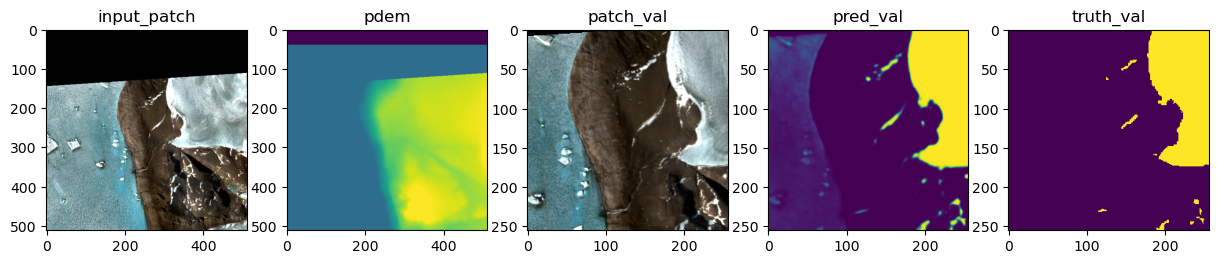

Ep221: tra-> Loss:0.010,Oa:0.980,Miou:0.957,                                 time:1.7s
Ep222: tra-> Loss:0.010,Oa:0.979,Miou:0.963,                                 time:1.8s
Ep222: tra-> Loss:0.009,Oa:0.973,Miou:0.951, val-> Loss:0.014,Oa:0.938, Miou:0.897,time:4.0s
Ep224: tra-> Loss:0.010,Oa:0.972,Miou:0.936,                                 time:1.6s
Ep225: tra-> Loss:0.012,Oa:0.974,Miou:0.938,                                 time:1.8s
Ep225: tra-> Loss:0.012,Oa:0.948,Miou:0.923, val-> Loss:0.014,Oa:0.938, Miou:0.895,time:3.9s
Ep227: tra-> Loss:0.011,Oa:0.985,Miou:0.964,                                 time:1.8s
Ep228: tra-> Loss:0.011,Oa:0.977,Miou:0.945,                                 time:1.8s
Ep228: tra-> Loss:0.011,Oa:0.964,Miou:0.935, val-> Loss:0.015,Oa:0.938, Miou:0.896,time:3.9s
Ep230: tra-> Loss:0.012,Oa:0.971,Miou:0.948,                                 time:1.6s
Ep231: tra-> Loss:0.011,Oa:0.972,Miou:0.948,                                 time:1.7s
Ep231: tra-> Loss:0.011,O

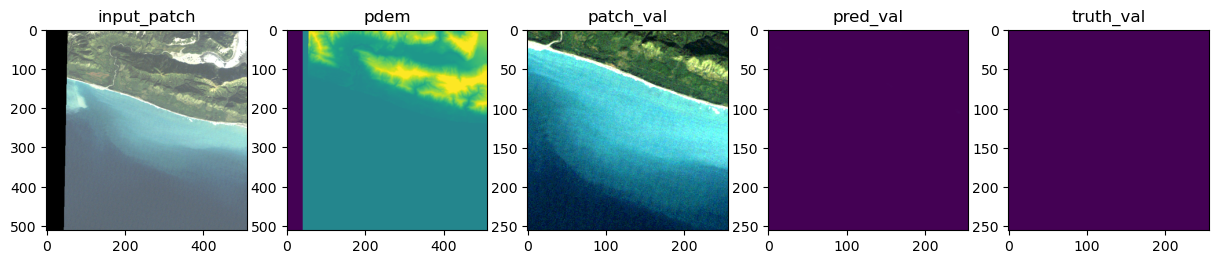

Ep281: tra-> Loss:0.013,Oa:0.977,Miou:0.955,                                 time:1.6s
Ep282: tra-> Loss:0.010,Oa:0.971,Miou:0.946,                                 time:1.8s
Ep282: tra-> Loss:0.011,Oa:0.981,Miou:0.956, val-> Loss:0.015,Oa:0.937, Miou:0.896,time:3.8s
Ep284: tra-> Loss:0.007,Oa:0.965,Miou:0.931,                                 time:1.7s
Ep285: tra-> Loss:0.010,Oa:0.974,Miou:0.951,                                 time:1.5s
Ep285: tra-> Loss:0.011,Oa:0.976,Miou:0.943, val-> Loss:0.015,Oa:0.937, Miou:0.896,time:3.9s
Ep287: tra-> Loss:0.009,Oa:0.978,Miou:0.956,                                 time:1.8s
Ep288: tra-> Loss:0.010,Oa:0.975,Miou:0.951,                                 time:1.7s
Ep288: tra-> Loss:0.012,Oa:0.980,Miou:0.952, val-> Loss:0.015,Oa:0.938, Miou:0.896,time:3.9s
Ep290: tra-> Loss:0.010,Oa:0.970,Miou:0.944,                                 time:1.7s
Ep291: tra-> Loss:0.009,Oa:0.950,Miou:0.929,                                 time:1.6s
Ep291: tra-> Loss:0.011,O

In [9]:
device = torch.device('cuda:0') 
metrics = train_loops(model=model, 
                epoches=300,  
                loss_fn=loss_mse,  
                optimizer=optimizer,  
                tra_loader=tra_loader,  
                val_loader=val_loader,  
                patch_size=patch_size,  
                patch_resize=None,  
                lr_scheduler=lr_scheduler,  
                device=device)  


In [10]:
# model saving
# model_name = 'unet' 
model_name = 'u2net_att'
# net_name = 'deeplabv3plus'
## net_name = 'deeplabv3plus_mb2'
# path_save = f'model/trained/patch_{patch_size}/{model_name}_weights_1.pth'
path_save = f'model/trained/{model_name}_{patch_size}/{model_name}_weights_dem_adjust_1.pth'
torch.save(model.state_dict(), path_save)     ## save weights of the trained model 
# # model.load_state_dict(torch.load(path_save, weights_only=True))  ## load the weights of the trained model
# # ## metrics saving
path_metrics = f'model/trained/{model_name}_{patch_size}/{model_name}_metrics_dem_adjust_1.csv'    
# path_metrics = f'model/trained/patch_{patch_size}/{model_name}_metrics_1.csv'    
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(path_metrics, index=False, sep=',')
